<a href="https://colab.research.google.com/github/victorliu5296/lottery-ticket-hypothesis/blob/main/Lottery_ticket_hypothesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune

# Define a simple fully connected network
class SimpleFC(nn.Module):
    def __init__(self):
        super(SimpleFC, self).__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
model = SimpleFC()

# Function to apply pruning and check non-zero parameters
def apply_pruning_and_check(model, pruning_perc, iteration):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    # Apply pruning iteratively, retaining previous masks
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_perc,
    )

    # Check the number of non-zero parameters
    print(f"\n--- Pruning Iteration {iteration} ---")
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            # The mask is not removed to preserve pruning for the next iteration
            print(f'{name}.weight non-zero: {torch.sum(module.weight != 0).item()}')

# Perform multiple pruning iterations on the untrained model
pruning_iterations = 5
pruning_percentage = 0.2  # Prune 20% of the remaining weights each time

for iteration in range(1, pruning_iterations + 1):
    apply_pruning_and_check(model, pruning_perc=pruning_percentage, iteration=iteration)



--- Pruning Iteration 1 ---
fc1.weight non-zero: 185796
fc2.weight non-zero: 26239
fc3.weight non-zero: 925

--- Pruning Iteration 2 ---
fc1.weight non-zero: 146407
fc2.weight non-zero: 23097
fc3.weight non-zero: 864

--- Pruning Iteration 3 ---
fc1.weight non-zero: 114832
fc2.weight non-zero: 20643
fc3.weight non-zero: 819

--- Pruning Iteration 4 ---
fc1.weight non-zero: 89666
fc2.weight non-zero: 18588
fc3.weight non-zero: 781

--- Pruning Iteration 5 ---
fc1.weight non-zero: 69471
fc2.weight non-zero: 17014
fc3.weight non-zero: 743


In [16]:
import torch
import torch.nn as nn
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_nonzero_parameters(model):
    return sum((p != 0).sum().item() for p in model.parameters() if p.requires_grad)

def prune_model(model, prune_percent):
    for name, param in model.named_parameters():
        if 'weight' in name:
            tensor = param.data.cpu().numpy()
            alive = tensor != 0
            percentile = np.percentile(np.abs(tensor[alive]), prune_percent)
            mask = np.abs(tensor) >= percentile
            tensor[~mask] = 0
            param.data = torch.from_numpy(tensor).to(param.device)

def pruning_experiment(prune_percent, prune_iterations):
    model = Net()
    original_params = count_parameters(model)
    print(f"Original parameter count: {original_params}")

    for iteration in range(prune_iterations):
        prune_model(model, prune_percent)
        current_params = count_nonzero_parameters(model)
        print(f"Iteration {iteration + 1}: Non-zero parameters: {current_params} ({current_params/original_params:.2%} of original)")

# Run the experiment
pruning_experiment(prune_percent=20, prune_iterations=5)

Original parameter count: 266610
Iteration 1: Non-zero parameters: 213370 (80.03% of original)
Iteration 2: Non-zero parameters: 170778 (64.06% of original)
Iteration 3: Non-zero parameters: 136704 (51.27% of original)
Iteration 4: Non-zero parameters: 109444 (41.05% of original)
Iteration 5: Non-zero parameters: 87636 (32.87% of original)


Training the baseline model...


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Baseline Model - Test loss: 0.0861, Accuracy: 97.39%
Baseline Model Size: 266200 non-zero parameters
Training Time: 132.15 seconds

--- Pruning Iteration 1 ---
Pruned Model Size: 212960 non-zero parameters (80.00% of original)
Retraining the pruned model...


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


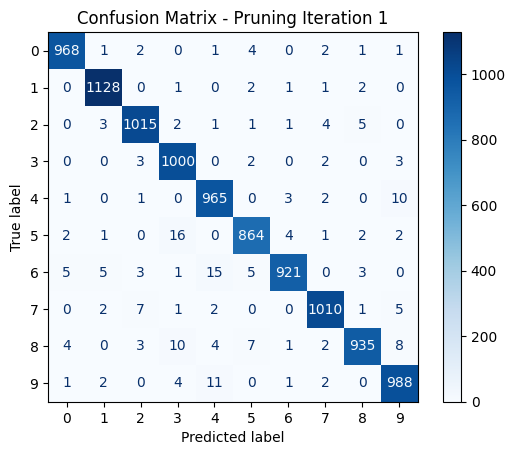

Pruned Model - Test loss: 0.0958, Accuracy: 97.94%
Training Time: 132.57 seconds

--- Pruning Iteration 2 ---
Pruned Model Size: 170368 non-zero parameters (64.00% of original)
Retraining the pruned model...


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


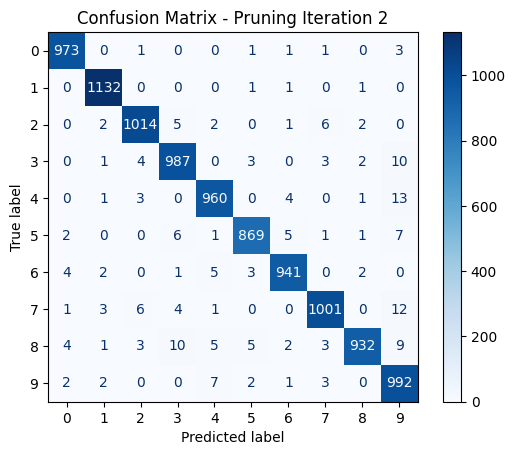

Pruned Model - Test loss: 0.1245, Accuracy: 98.01%
Training Time: 132.28 seconds

--- Pruning Iteration 3 ---
Pruned Model Size: 136294 non-zero parameters (51.20% of original)
Retraining the pruned model...


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


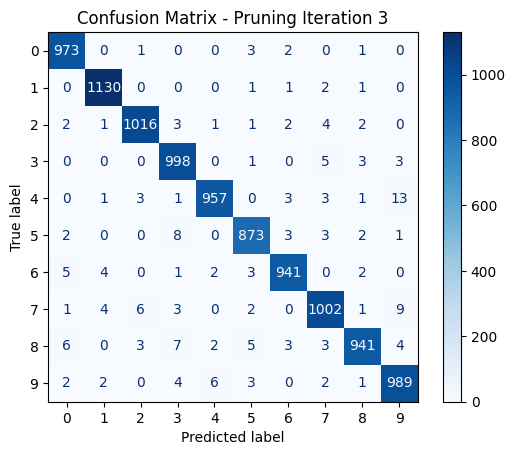

Pruned Model - Test loss: 0.1155, Accuracy: 98.20%
Training Time: 134.89 seconds

--- Pruning Iteration 4 ---
Pruned Model Size: 109035 non-zero parameters (40.96% of original)
Retraining the pruned model...


Testing: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


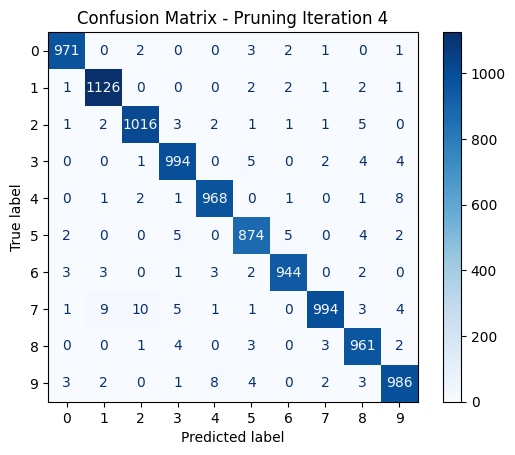

Pruned Model - Test loss: 0.1315, Accuracy: 98.34%
Training Time: 146.25 seconds

--- Pruning Iteration 5 ---
Pruned Model Size: 87228 non-zero parameters (32.77% of original)
Retraining the pruned model...


Epoch 3 Training:  70%|██████▉   | 655/938 [00:19<00:08, 35.04it/s]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import time
from tqdm import tqdm

# Step 1: Define the Network
class SimpleFC(nn.Module):
    def __init__(self):
        super(SimpleFC, self).__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Step 2: Load the MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Step 3: Train the Baseline Network
def train(model, device, train_loader, optimizer, epoch, losses, accuracies):
    model.train()
    epoch_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch} Training")):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    losses.append(epoch_loss / len(train_loader))
    accuracies.append(100. * correct / len(train_loader.dataset))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Testing"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy, np.array(all_preds), np.array(all_targets)

def count_nonzero_parameters(model):
    nonzero_params = 0
    for module in model.modules():
        if isinstance(module, nn.Linear):
            nonzero_params += torch.sum(module.weight != 0).item()
    return nonzero_params

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleFC().to(device)
optimizer = optim.Adam(model.parameters())

# Variables for tracking results
original_nonzero_params = count_nonzero_parameters(model)
pruning_iterations = 5
pruning_percentage = 0.2
all_accuracies = []
all_model_sizes = []
all_times = []
train_losses = []
train_accuracies = []

print("Training the baseline model...")
start_time = time.time()
for epoch in range(1, 6):
    train(model, device, train_loader, optimizer, epoch, train_losses, train_accuracies)
test_loss, accuracy, _, _ = test(model, device, test_loader)
end_time = time.time()

baseline_time = end_time - start_time
all_accuracies.append(accuracy)
all_model_sizes.append(original_nonzero_params)
all_times.append(baseline_time)

print(f'Baseline Model - Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
print(f'Baseline Model Size: {original_nonzero_params} non-zero parameters')
print(f'Training Time: {baseline_time:.2f} seconds')

# Step 4: Iterative Pruning and Retraining
def prune_weights_and_retain_masks(model, pruning_perc):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    # Apply pruning without removing the pruning mask
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_perc,
    )

for iteration in range(1, pruning_iterations + 1):
    print(f'\n--- Pruning Iteration {iteration} ---')

    # Prune the model and retain masks
    prune_weights_and_retain_masks(model, pruning_percentage)

    # Check the number of remaining non-zero parameters
    pruned_nonzero_params = count_nonzero_parameters(model)
    print(f'Pruned Model Size: {pruned_nonzero_params} non-zero parameters ({100 * pruned_nonzero_params / original_nonzero_params:.2f}% of original)')

    # Reinitialize and retrain the pruned model
    print("Retraining the pruned model...")
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)

    optimizer = optim.Adam(model.parameters())

    iteration_losses = []
    iteration_accuracies = []

    start_time = time.time()
    for epoch in range(1, 6):
        train(model, device, train_loader, optimizer, epoch, iteration_losses, iteration_accuracies)
    test_loss, accuracy, preds, targets = test(model, device, test_loader)
    end_time = time.time()

    # Track the results
    all_accuracies.append(accuracy)
    all_model_sizes.append(pruned_nonzero_params)
    all_times.append(end_time - start_time)

    # Confusion Matrix
    cm = confusion_matrix(targets, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - Pruning Iteration {iteration}')
    plt.show()

    print(f'Pruned Model - Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    print(f'Training Time: {end_time - start_time:.2f} seconds')

# Step 5: Visualizations

# Accuracy vs Model Size
plt.figure(figsize=(10, 5))
plt.plot(all_model_sizes, all_accuracies, marker='o')
plt.xlabel('Number of Non-Zero Parameters')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Model Size')
plt.grid(True)
plt.show()

# Accuracy vs Training Time
plt.figure(figsize=(10, 5))
plt.plot(all_times, all_accuracies, marker='o')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Training Time')
plt.grid(True)
plt.show()

# Training Loss and Accuracy over Epochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs')

plt.tight_layout()
plt.show()
